<h2>Introduction</h2>

This notebook provides examples for working with MIBI data in the form of a MibiImage instance, which is a class in the `mibidata` module of the [mibilib](https://github.com/ionpath/mibilib/tree/master/mibidata) library. Complete documentation for the module is available [here](https://ionpath.github.io/mibilib/mibidata.html#module-mibidata).

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import os

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from skimage import filters

from mibidata.mibi_image import MibiImage
from mibidata import color, tiff
from mibitracker import request_helpers

matplotlib.rcParams.update({
    'font.size': 8,
    'axes.grid': False,
})

<h2>Creating a MibiImage Instance</h2>

A MibiImage instance can be created with as little as a numpy array of count data and a list of channel names. Additional args in the constructor allow you to add relevant metadata, including run name and point name. For a full list of metadata args, see the [class documentation](https://ionpath.github.io/mibilib/mibidata.html#module-mibidata.mibi_image). Note that channels can be specified as either a list of integer masses, a list of string channel names, or a list of tuples of (integer mass, string channel name).

#### From a numpy array

In [2]:
# Create some random channel data. MIBI data is typically 16-bit uint, so
# limit range to (0, 65535). Image size here is 128 x 128 pixels with 3
# channels.
random_channel_data = np.random.randint(0, 65535, (128, 128, 3), dtype=np.uint16)
channels = ['Channel 1', 'Channel 2', 'Channel 3']
random_mibi_image = MibiImage(
    random_channel_data, channels,
    run='Random Run', point_name='Random Point Name')
print(random_mibi_image)
for key, val in random_mibi_image.metadata().items():
    print(f'{key}: {val}')

<class 'mibidata.mibi_image.MibiImage'> {run: Random Run, date: None, coordinates: None, size: None, slide: None, point_name: Random Point Name, folder: None, dwell: None, scans: None, aperture: None, instrument: None, tissue: None, panel: None, version: None, mass_offset: None, mass_gain: None, time_resolution: None, miscalibrated: None, check_reg: None, filename: None}
run: Random Run
date: None
coordinates: None
size: None
slide: None
point_name: Random Point Name
folder: None
dwell: None
scans: None
aperture: None
instrument: None
tissue: None
panel: None
version: None
mass_offset: None
mass_gain: None
time_resolution: None
miscalibrated: None
check_reg: None
filename: None


The most common and easiest way to import data into a MibiImage instance is to use the [mibidata.tiff.read](https://ionpath.github.io/mibilib/mibidata.html#module-mibidata.tiff) method. This method loads a Multiplexed MIBITIFF file that has been saved in the MIBITIFF format, which is the output of the IONpath TIFF Generator. In this case, all of the metadata is already saved with the image, and so the filename is the only parameter necessary.

#### From a local file

In [ ]:
image = tiff.read('/path/to/mibi_tiff.tiff')
image

#### From MIBItracker

In [3]:
# Load MIBItracker credentials from file.
# For details about credentials, please review the 'MIBItracker_API_Tutorial.ipynb' notebook.
from dotenv import load_dotenv
fname_login = '/path/to/MIBItracker_login.dat'
load_dotenv(fname_login)

# This assumes your MIBItracker credentials are saved as environment variables.
mr = request_helpers.MibiRequests(
    os.getenv('MIBITRACKER_PUBLIC_URL'),
    os.getenv('MIBITRACKER_PUBLIC_EMAIL'),
    os.getenv('MIBITRACKER_PUBLIC_PASSWORD')
)
image_ids = (17, 26)
images = []
for image_id in image_ids:
    im = mr.get_mibi_image(image_id)
    images.append(im)

<h2>MibiImage Slicing</h2>

Once loaded or created, the MibiImage class provides convenience methods for slicing, copying, and saving MIBI data. For example, we can select out certain channels of interest from the entire multiplexed image. An image can be sliced using a list of channel names either with the `slice_data` method or indexing.

In [4]:
image = images[0]
image.channels

((166, 'beta-tubulin'),
 (144, 'CD11c'),
 (159, 'CD3'),
 (174, 'CD31'),
 (143, 'CD4'),
 (175, 'CD45'),
 (150, 'CD56'),
 (156, 'CD68'),
 (158, 'CD8'),
 (89, 'dsDNA'),
 (146, 'FOXP3'),
 (160, 'HLA class 1 A, B, and C'),
 (165, 'Keratin'),
 (154, 'Lamin A/C'),
 (176, 'Na-K-ATPase alpha1'),
 (149, 'PD-L1'),
 (151, 'Vimentin'))

In [5]:
data_of_interest = image['dsDNA', 'beta-tubulin', 'HLA class 1 A, B, and C', 'Na-K-ATPase alpha1']
print(type(data_of_interest), np.shape(data_of_interest))

<class 'numpy.ndarray'> (1024, 1024, 4)


If the channel masses are provided, they can also be used to slice the data.

In [6]:
data_of_interest = image[89, 166, 160, 176]
print(type(data_of_interest), np.shape(data_of_interest))

<class 'numpy.ndarray'> (1024, 1024, 4)


The above commands that slice the data by index are equivalent to `MibiImage.slice_data()`.

To create a new MibiImage instance from a subset of the channel, use `MibiImage.slice_image()`.

In [7]:
sub_image = image.slice_image(['dsDNA', 'beta-tubulin', 'HLA class 1 A, B, and C', 'Na-K-ATPase alpha1'])
print(type(sub_image), np.shape(sub_image.data))

<class 'mibidata.mibi_image.MibiImage'> (1024, 1024, 4)


<h2>Image Visualization</h2>

We can
- slice out three channels for a simple RGB view
- rotate that to CYM
- use the `mibidata.color.composite` method to select a hue
- use the `mibidata.color.composite` with up to 8 different colors

<IPython.core.display.Javascript object>


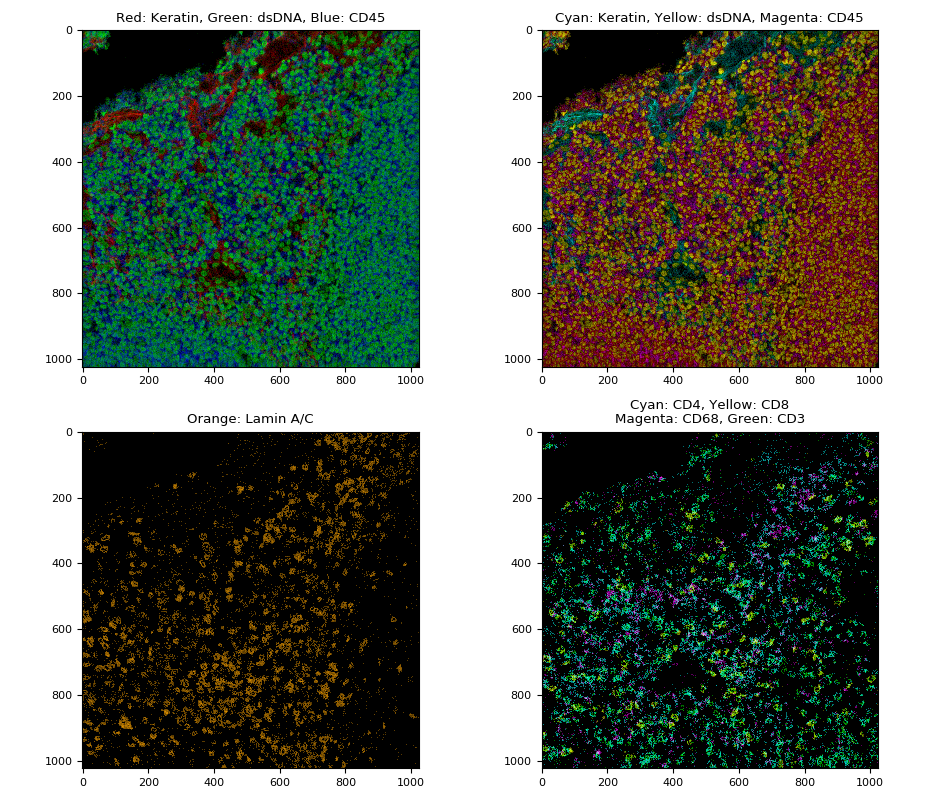

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(9.5, 8))

rgb = image[['Keratin', 'dsDNA', 'CD45']]
rgb = np.power(rgb / rgb.max(axis=(0, 1)), 1/2)
ax[0, 0].imshow(rgb)
ax[0, 0].set_title('Red: Keratin, Green: dsDNA, Blue: CD45')

cym = color.rgb2cym(rgb)
ax[0, 1].imshow(cym)
ax[0, 1].set_title('Cyan: Keratin, Yellow: dsDNA, Magenta: CD45')

ax[1, 0].imshow(color.composite(image, {'Orange': 'Lamin A/C'}))
ax[1, 0].set_title('Orange: Lamin A/C')

overlay = color.composite(
    image,
    {
        'Green': 'CD3',
        'Cyan': 'CD4',
        'Yellow': 'CD8',
        'Magenta': 'CD68'
    })
ax[1, 1].imshow(overlay)
ax[1, 1].set_title('Cyan: CD4, Yellow: CD8\n'
                'Magenta: CD68, Green: CD3')

fig.tight_layout()

<h2>Image Manipluation</h2>

A deep copy of MibiImage instances can be made using the `copy` method.

In [9]:
new_image = image.copy()
new_image.channels

((166, 'beta-tubulin'),
 (144, 'CD11c'),
 (159, 'CD3'),
 (174, 'CD31'),
 (143, 'CD4'),
 (175, 'CD45'),
 (150, 'CD56'),
 (156, 'CD68'),
 (158, 'CD8'),
 (89, 'dsDNA'),
 (146, 'FOXP3'),
 (160, 'HLA class 1 A, B, and C'),
 (165, 'Keratin'),
 (154, 'Lamin A/C'),
 (176, 'Na-K-ATPase alpha1'),
 (149, 'PD-L1'),
 (151, 'Vimentin'))

To alter channel data in the image, you can access the `.data` property with the indices of the channels of interest.

<IPython.core.display.Javascript object>


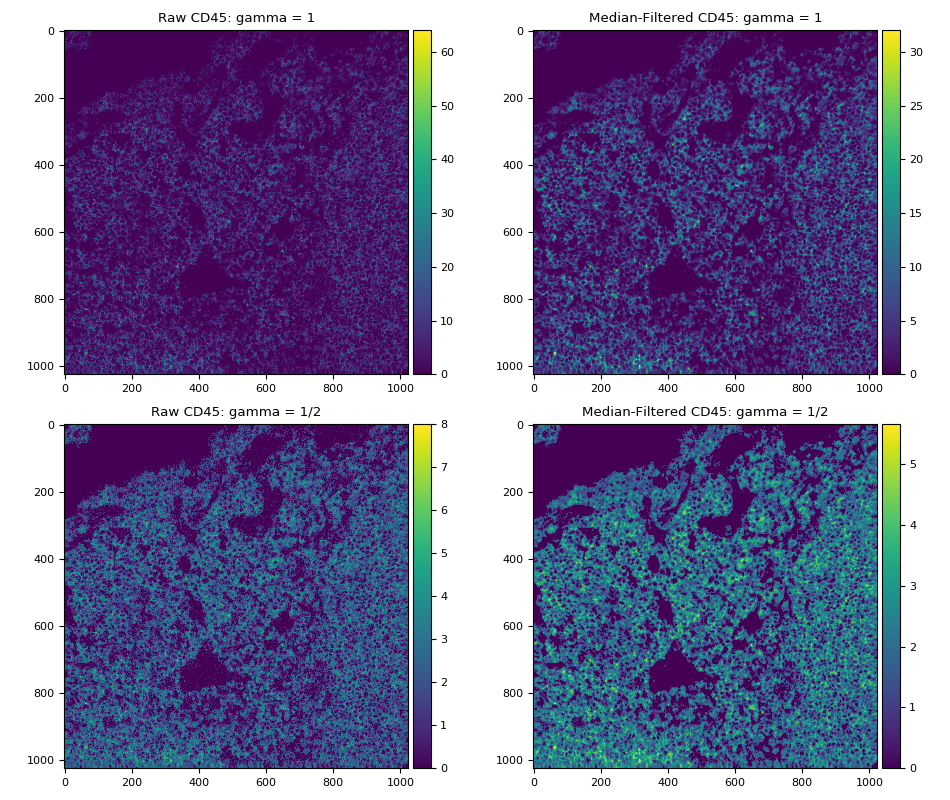

In [10]:
new_image.data[:, :, new_image.channel_inds('CD45')] = filters.median(image['CD45'])

def show_image(data, axis, title):
    cb = axis.imshow(data)
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(cb, cax=cax)
    axis.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(9.5, 8))
show_image(image['CD45'], ax[0, 0], 'Raw CD45: gamma = 1')
show_image(new_image['CD45'], ax[0, 1], 'Median-Filtered CD45: gamma = 1')
show_image(np.power(image['CD45'], 1/2), ax[1, 0],
            'Raw CD45: gamma = 1/2')
show_image(np.power(new_image['CD45'], 1/2), ax[1, 1],
            'Median-Filtered CD45: gamma = 1/2')
fig.tight_layout()

Rather than scaling a single channel, we can also apply a default scaling to all channels, and then display an RGB overlay of a 3-D slice.

In [11]:
def scale(image, gamma=1/2):
    """Scales each 2-D slice of an N-D image to a brightened version in the [0, 1] range."""
    
    scaled = np.divide(
        image.data.astype(np.float),
        image.data.max(axis=(0, 1)))
    scaled = np.power(scaled, gamma)
    image.data = scaled

<IPython.core.display.Javascript object>


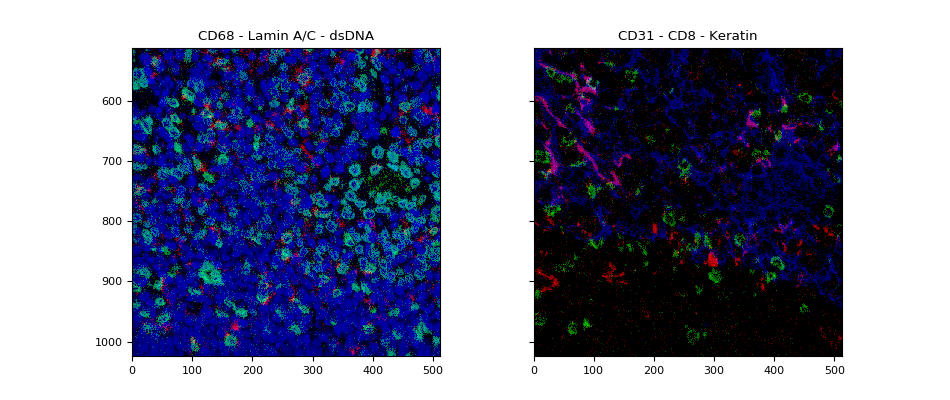

(1024, 512)

In [12]:
scaled_image = image.copy()
scale(scaled_image, 1/3)

fig, ax = plt.subplots(1, 2, figsize=(9.5, 4), sharex=True, sharey=True)

ax[0].imshow(scaled_image[['CD68', 'Lamin A/C', 'dsDNA']])
ax[0].set_title('CD68 - Lamin A/C - dsDNA')
ax[1].imshow(scaled_image[['CD31', 'CD8', 'Keratin']])
ax[1].set_title('CD31 - CD8 - Keratin')

ax[0].set_xlim((0, 512))
ax[0].set_ylim((1024, 512))

<h2>Saving MibiImages</h2>

A MibiImage object can be saved as either a multiplexed MIBITIFF or a series of individual channel PNGs.

When saving a series of channel PNGs, the folder to save to must be specified. The filenames of each PNG will be generated from the channel names of the MibiImage object, either the string label or the target only if they the channels are (mass, target) tuples.

In [ ]:
tiff.write('/path/to/file.tiff', new_image)

In [ ]:
new_image.export_pngs('/path/to/folder')
outputs = [png_name for png_name in os.listdir('/path/to/folder/') if os.path.splitext(png_name)[-1] == '.png']
outputs

The exported TIFF or PNGs can then be uploaded to MIBItracker using the `mibitracker` module. See the Python section of the [MIBItracker Tutorial](https://github.com/ionpath/mibilib/blob/master/MIBItracker_API_Tutorial.ipynb) for more information on uploading TIFF or PNG files.